In [1]:
###Importing packages we need###

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import metpy.calc as mpcalc
from metpy.units import units
from matplotlib.lines import Line2D
from numpy import *
import xarray as xr
from netCDF4 import Dataset, num2date
from scipy.stats import ttest_ind
import math
import pygrib
import glob
import matplotlib.patches as patches
import cdsapi
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import metpy as mp
import os
import warnings
warnings.filterwarnings("ignore")

print("Done importing modules")

Done importing modules


In [46]:
###Import the 3 CF tables and concatenate###

#Read in the 3 tables#
dfg = pd.read_csv('CSV_DFs/CF_good.csv')
dfmf = pd.read_csv('CSV_DFs/CF_mf_updated.csv')
dfu = pd.read_csv('CSV_DFs/CF_unclear_updated_new.csv')
                  
#Combine into 1 big file with all CF cases and reset index#
dfall = pd.concat([dfg, dfmf, dfu])
dfall.reset_index(drop=True, inplace=True)

#Convert 'date' column to datetime if it is not already#
dfall['date'] = pd.to_datetime(dfall['date'])

#Sort the DataFrame by 'date' and del duplicate#
dfall_sort = dfall.sort_values(by='date').reset_index(drop=True)
dfall_sort = dfall_sort.drop(260)
dfall_sort = dfall_sort.sort_values(by='date').reset_index(drop=True)

#Import the df#
df_LP = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_Low_Precip.csv')
df_HP = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_High_Precip.csv')

#Select the subsample for ts analysis#
#dfall_half = dfall_sort[0:362]
dfall_select = df_LP.copy()
dfall_select


,date,max_value,max_time,file_date,total_precip
0,1950-11-02,625.744615,1950-11-01 10:00:00,1950-11-02,0.039172
1,1950-12-27,1011.129758,1950-12-26 15:00:00,1950-12-27,61.792616
2,1951-01-28,2451.093687,1951-01-27 05:00:00,1951-01-28,4.875601
3,1951-03-09,5164.179325,1951-03-08 09:00:00,1951-03-09,9.902985
4,1951-03-24,2864.818543,1951-03-23 08:00:00,1951-03-24,13.509710
...,...,...,...,...,...
140,2021-11-01,672.486578,2021-10-31 06:00:00,2021-11-01,15.182394
141,2021-11-09,393.261911,2021-11-09 02:00:00,2021-11-09,9.922114
142,2021-11-18,3125.050762,2021-11-17 10:00:00,2021-11-18,62.295407
143,2021-12-07,10677.291980,2021-12-06 01:00:00,2021-12-07,7.024482


In [47]:
###Import a test case to see the climo files for anomaly computing###

climo_path = '/projects/zami4053/Synoptic_Research/Climatologies/climatology_1950-01-22 00:00:00.nc'
climo_test = xr.open_dataset(climo_path)
climo_test

data_dirtest = xr.open_dataset("/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_01_01_2011.nc")
data_dirtest

<xarray.Dataset>
Dimensions:    (longitude: 53, latitude: 41, time: 72)
Coordinates:
  * longitude  (longitude) float32 -112.0 -111.8 -111.5 ... -99.5 -99.25 -99.0
  * latitude   (latitude) float32 44.0 43.75 43.5 43.25 ... 34.5 34.25 34.0
  * time       (time) datetime64[ns] 2010-12-30 ... 2011-01-01T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-22 04:31:17 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [14]:
# # Directory containing the NetCDF files
# data_dir = "/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/"

# # Sort the NetCDF files
# file_list = sorted(glob.glob(data_dir + "*.nc"))

# # Initialize an empty list to store DataArrays
# aligned_data_arrays = []
# insufficient_data_files = []

# # Extract dates from filenames
# file_dates = [pd.to_datetime('_'.join(file.split('_')[-3:]).split('.')[0], format="%m_%d_%Y") for file in file_list]

# # Add a new column to dfall with the formatted dates from the filenames
# dfall['file_date'] = pd.to_datetime(dfall['date'])

# # Sort both lists by date to ensure alignment
# dfall = dfall.sort_values('file_date').reset_index(drop=True)
# sorted_files_with_dates = sorted(zip(file_dates, file_list))

# # Loop through each row in dfall and find the corresponding file
# file_idx = 0

# for i, row in dfall[0:5].iterrows():
#     while file_idx < len(sorted_files_with_dates) and sorted_files_with_dates[file_idx][0] < row['file_date']:
#         file_idx += 1

#     if file_idx >= len(sorted_files_with_dates):
#         break

#     file_date, file = sorted_files_with_dates[file_idx]

#     if file_date != row['file_date']:
#         print(f"Skipping date {row['file_date']} due to no matching file")
#         continue

#     # Open each file
#     ds = xr.open_dataset(file)
#     selected_data = ds.sel(latitude=37.5, longitude=-103.0)['t2m']  # Select a grid cell and variable here
#     max_time = pd.to_datetime(row['max_time'])

#     # Calculate start and end times for the 25-hour period
#     hours_sel = 12
#     start_time = max_time - timedelta(hours=hours_sel)  # can adjust
#     end_time = max_time + timedelta(hours=hours_sel)    # can adjust
#     time_array = pd.date_range(start=start_time, end=end_time, freq='H')
#     print(time_array)

#     # Select the data for the 25-hour period
#     selected_data_t = selected_data.sel(time=slice(start_time, end_time))

#     # Only include the data if it has the full 25-hour period
#     if selected_data_t.shape[0] == hours_sel*2+1:
#         aligned_data_arrays.append(selected_data_t)
#     else:
#         print(f"Skipping file {file} due to insufficient data")
#         insufficient_data_files.append((file, selected_data_t.time.values))

# # Handle files with insufficient data
# for file, times in insufficient_data_files:
#     # Create an array of NaNs with the required shape
#     full_times = pd.date_range(start=start_time, end=end_time, freq='H')
#     nan_data = xr.DataArray(np.full((hours_sel*2+1,), np.nan), dims=['time'], coords={'time': full_times})
#     aligned_data_arrays.append(nan_data)

In [48]:
###Extract the 25 hour periods centered at t=0 and compute anomalies###

#Directory containing the NetCDF files and climo files#
data_dir = "/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/"
climo_dir = "/projects/zami4053/Synoptic_Research/Climatologies/"

#Sort the NetCDF files#
file_list = sorted(glob.glob(data_dir + "*.nc"))

#Initialize an empty list to store DataArrays#
aligned_data_arrays = []
insufficient_data_files = []

#Extract dates from filenames and convert to datetime#
file_dates = [pd.to_datetime('_'.join(file.split('_')[-3:]).split('.')[0], format="%m_%d_%Y") for file in file_list]
dfall_select['file_date'] = pd.to_datetime(dfall_select['date'])

#Sort both lists by date to ensure alignment#
dfall = dfall_select.sort_values('file_date').reset_index(drop=True)
sorted_files_with_dates = sorted(zip(file_dates, file_list))

#Loop through each row in dfall and find the corresponding file#
file_idx = 0
#var_2_sel = 'u10'

for i, row in dfall.iterrows():  #can change from all to a few cases
    while file_idx < len(sorted_files_with_dates) and sorted_files_with_dates[file_idx][0] < row['file_date']:    
        file_idx += 1

    if file_idx >= len(sorted_files_with_dates):
        break

    file_date, file = sorted_files_with_dates[file_idx]

    if file_date != row['file_date']:
        print(f"Skipping date {row['file_date']} due to no matching file")
        continue

    #Open each file and sel gridpoint and var#
    ds = xr.open_dataset(file)
    selected_data = ds.sel(latitude=37.5, longitude=-103.0)['sp'] #Select a grid cell and variable here
    max_time = pd.to_datetime(row['max_time'])

    #Calculate start and end times for the 25-hour period#
    hours_sel = 12
    start_time = max_time - timedelta(hours=hours_sel)   #can adjust
    end_time = max_time + timedelta(hours=hours_sel)     #can adjust
    time_array = pd.date_range(start=start_time, end=end_time, freq='H')
    #print(time_array)

    #Select the data for the 25-hour period#
    selected_data_t = selected_data.sel(time=slice(start_time, end_time))

    #Only include the data if it has the full 25-hour period#
    if selected_data_t.shape[0] == hours_sel*2+1:
        
        #Initialize an empty list to store anomalies#
        anomalies = []

        #Loop through each hour in the 25-hour period to construct anomalies#
        for time in time_array:
            
            #Construct the file path for the climatology file and handle edge cases#
            if time.month in [6, 7, 8]:
                climo_file = os.path.join(climo_dir, "climatology_1950-09-01 00:00:00.nc")
                
            elif time.month == 2 and time.day == 29:
                climo_file = os.path.join(climo_dir, "climatology_1950-03-01 00:00:00.nc")
            
            else:
                climo_file = os.path.join(climo_dir, f"climatology_1950-{time.strftime('%m-%d')} 00:00:00.nc")
                
            if not os.path.exists(climo_file):
                print(f"Climatology file not found: {climo_file}")
                continue
            
            #Open the files and sel the same gridpoint and variable#
            climo_ds = xr.open_dataset(climo_file)
            climo_t2m = climo_ds.sel(latitude=37.5, longitude=-103.0)['sp']           #can adjust this

            #Calculate the anomaly#
            anomaly = selected_data_t.sel(time=time) - climo_t2m
            anomalies.append(anomaly)

        #Combine anomalies into a single DataArray#
        anomalies_da = xr.concat(anomalies, dim='time')
        aligned_data_arrays.append(anomalies_da)
    
    else:
        print(f"Skipping file {file} due to insufficient data")
        insufficient_data_files.append((file, selected_data_t.time.values))

#Handle files with insufficient data and fill with Nans#
for file, times in insufficient_data_files:
    
    #Create an array of NaNs with the required shape#
    full_times = pd.date_range(start=start_time, end=end_time, freq='H')
    nan_data = xr.DataArray(np.full((hours_sel*2+1,), np.nan), dims=['time'], coords={'time': full_times})
    
    #Append to the total array#
    aligned_data_arrays.append(nan_data)

Skipping file /pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_03_01_1995.nc due to insufficient data
Skipping file /pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_03_02_2002.nc due to insufficient data
Skipping file /pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_02_02_2017.nc due to insufficient data


In [6]:
###Extract the 25 hour periods centered at t=0 for anomalies###

#Directory containing the NetCDF files and climo files#
data_dir = "/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/"
climo_dir = "/projects/zami4053/Synoptic_Research/Climatologies/"

#Sort the NetCDF files#
file_list = sorted(glob.glob(data_dir + "*.nc"))

#Initialize an empty list to store DataArrays#
aligned_data_arrays = []
insufficient_data_files = []

#Extract dates from filenames and convert to datetime#
file_dates = [pd.to_datetime('_'.join(file.split('_')[-3:]).split('.')[0], format="%m_%d_%Y") for file in file_list]
dfall_select['file_date'] = pd.to_datetime(dfall_select['date'])

#Sort both lists by date to ensure alignment#
dfall = dfall_select.sort_values('file_date').reset_index(drop=True)
sorted_files_with_dates = sorted(zip(file_dates, file_list))

#Loop through each row in dfall and find the corresponding file#
file_idx = 0
var_2_sel = 'u10'

for i, row in dfall.iterrows():  #can change from all to a few cases
    while file_idx < len(sorted_files_with_dates) and sorted_files_with_dates[file_idx][0] < row['file_date']:    
        file_idx += 1

    if file_idx >= len(sorted_files_with_dates):
        break

    file_date, file = sorted_files_with_dates[file_idx]

    if file_date != row['file_date']:
        print(f"Skipping date {row['file_date']} due to no matching file")
        continue

    #Open each file and sel gridpoint and var#
    ds = xr.open_dataset(file)
    selected_data = ds.sel(latitude=37.5, longitude=-103.0)[var_2_sel]          #Select a grid cell and variable here
    max_time = pd.to_datetime(row['max_time'])

    #Calculate start and end times for the 25-hour period#
    hours_sel = 12
    start_time = max_time - timedelta(hours=hours_sel)   #can adjust
    end_time = max_time + timedelta(hours=hours_sel)     #can adjust
    time_array = pd.date_range(start=start_time, end=end_time, freq='H')
    #print(time_array)

    #Select the data for the 25-hour period#
    selected_data_t = selected_data.sel(time=slice(start_time, end_time))

    #Only include the data if it has the full 25-hour period#
    if selected_data_t.shape[0] == hours_sel*2+1:
        
        aligned_data_arrays.append(selected_data_t)
    
    else:
        
        print(f"Skipping file {file} due to insufficient data")
        insufficient_data_files.append((file, selected_data_t.time.values))

#Handle files with insufficient data and fill with Nans#
for file, times in insufficient_data_files:
    
    #Create an array of NaNs with the required shape#
    full_times = pd.date_range(start=start_time, end=end_time, freq='H')
    nan_data = xr.DataArray(np.full((hours_sel*2+1,), np.nan), dims=['time'], coords={'time': full_times})
    
    #Append to the total array#
    aligned_data_arrays.append(nan_data)

Skipping file /pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_04_11_2013.nc due to insufficient data


In [31]:
###Extract the 25 hour periods centered at t=0 for winds only ###

#Directory containing the NetCDF files and climo files#
data_dir = "/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/"
climo_dir = "/projects/zami4053/Synoptic_Research/Climatologies/"

#Sort the NetCDF files#
file_list = sorted(glob.glob(data_dir + "*.nc"))

#Initialize an empty list to store DataArrays#
aligned_data_arrays = []
insufficient_data_files = []

#Extract dates from filenames and convert to datetime#
file_dates = [pd.to_datetime('_'.join(file.split('_')[-3:]).split('.')[0], format="%m_%d_%Y") for file in file_list]
dfall_select['file_date'] = pd.to_datetime(dfall_select['date'])

#Sort both lists by date to ensure alignment#
dfall = dfall_select.sort_values('file_date').reset_index(drop=True)
sorted_files_with_dates = sorted(zip(file_dates, file_list))

#Loop through each row in dfall and find the corresponding file#
file_idx = 0
var_2_sel = 'v10'

for i, row in dfall.iterrows():  #can change from all to a few cases
    while file_idx < len(sorted_files_with_dates) and sorted_files_with_dates[file_idx][0] < row['file_date']:    
        file_idx += 1

    if file_idx >= len(sorted_files_with_dates):
        break

    file_date, file = sorted_files_with_dates[file_idx]

    if file_date != row['file_date']:
        print(f"Skipping date {row['file_date']} due to no matching file")
        continue

    #Open each file and sel gridpoint and var#
    ds = xr.open_dataset(file)
    selected_data = ds.sel(latitude=37.5, longitude=-103.0)[var_2_sel]          #Select a grid cell and variable here
    max_time = pd.to_datetime(row['max_time'])

    #Calculate start and end times for the 25-hour period#
    hours_sel = 12
    start_time = max_time - timedelta(hours=hours_sel)   #can adjust
    end_time = max_time + timedelta(hours=hours_sel)     #can adjust
    time_array = pd.date_range(start=start_time, end=end_time, freq='H')
    #print(time_array)

    #Select the data for the 25-hour period#
    selected_data_t = selected_data.sel(time=slice(start_time, end_time))

    #Only include the data if it has the full 25-hour period#
    if selected_data_t.shape[0] == hours_sel*2+1:
        
        aligned_data_arrays.append(selected_data_t)
    
    else:
        
        print(f"Skipping file {file} due to insufficient data")
        insufficient_data_files.append((file, selected_data_t.time.values))

#Handle files with insufficient data and fill with Nans#
for file, times in insufficient_data_files:
    
    #Create an array of NaNs with the required shape#
    full_times = pd.date_range(start=start_time, end=end_time, freq='H')
    nan_data = xr.DataArray(np.full((hours_sel*2+1,), np.nan), dims=['time'], coords={'time': full_times})
    
    #Append to the total array#
    aligned_data_arrays.append(nan_data)

Skipping file /pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_04_11_2013.nc due to insufficient data


In [49]:
###Temporily store these in arrays###

len(aligned_data_arrays)

145

In [50]:
##Reshape and fix the xr###
def fix_array(arr): 
    '''Reshapes the array and converts to an xr for easy use'''
    
    #Combine all the aligned DataArrays along a new dimension#
    aligned_combined_data = xr.concat(arr, dim='time', coords='minimal')
    global case_N
    case_N = int(len(aligned_combined_data['time']) / 25)

    #Reshape the array#
    reshaped_data = aligned_combined_data.values.reshape(case_N, 25)
    reshaped_data

    #Convert back to xr with proper dimensions and coordinates#
    reshaped_data_array = xr.DataArray(reshaped_data, dims=['CF_events', 'time'], coords={'CF_events': np.arange(case_N), 'time': np.arange(25)})
    
    return reshaped_data_array

#Do these one by one#
LP_array = fix_array(aligned_data_arrays)
#HP_array = fix_array(aligned_data_arrays)

In [51]:
#HP_array 
LP_array

<xarray.DataArray (CF_events: 145, time: 25)>
array([[-822.4140625, -896.9296875, -884.359375 , ...,  210.359375 ,
         166.8984375,  185.046875 ],
       [-364.5625   , -262.8359375, -158.1796875, ...,  373.2421875,
         398.5546875,  380.546875 ],
       [-567.8046875, -670.7890625, -802.765625 , ..., -287.90625  ,
        -271.4140625, -263.9140625],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])
Coordinates:
  * CF_events  (CF_events) int64 0 1 2 3 4 5 6 7 ... 138 139 140 141 142 143 144
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24

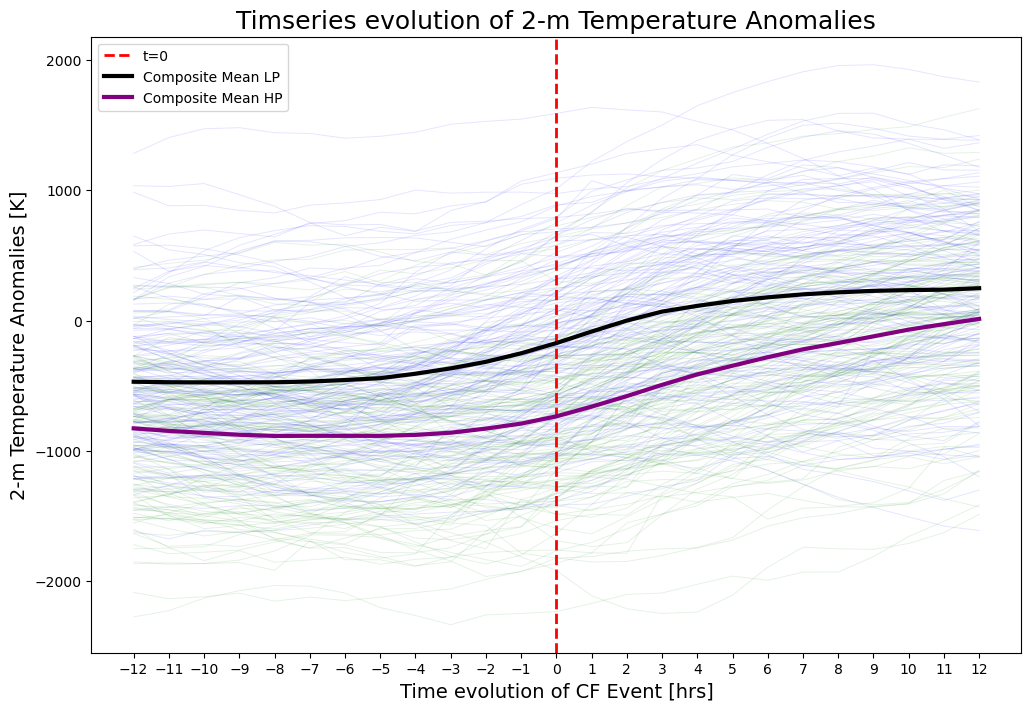

In [52]:
###Make sure the timseries are working properly along with the composite###

#Plot all the time series#
plt.figure(figsize=(12, 8))

#Create the time lag array
time_values = np.arange(-12, 13, 1)  

for i in range(LP_array.shape[0]):
    
    plt.plot(time_values, LP_array[i, :], color='blue', alpha=0.1, linewidth=0.7)
    
for i in range(HP_array.shape[0]):
    
    plt.plot(time_values, HP_array[i, :], color='green', alpha=0.1, linewidth=0.7)
    
plt.xlabel('Time evolution of CF Event [hrs]', fontsize=14)
plt.ylabel('2-m Temperature Anomalies [K]', fontsize=14)
plt.title('Timseries evolution of 2-m Temperature Anomalies', fontsize=18)

#Add a vertical line at t=0 (index 13)#
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='t=0')

#Calculate and plot the average line#
average_time_series = LP_array.mean(dim='CF_events')
plt.plot(time_values, average_time_series, color='black', linewidth=3, label='Composite Mean LP')
plt.legend()

average_time_series2 = HP_array.mean(dim='CF_events')
plt.plot(time_values, average_time_series2, color='purple', linewidth=3, label='Composite Mean HP')
plt.legend()

#Draw vertical lines where the y-values are positive#
#positive_indices = np.where(average_time_series > 0.5)[0]

#Add the sample size#
#plt.annotate(f'N={case_N}', xy=(8.5, 11), xytext=(8.5, 11), fontsize=12)

# if len(positive_indices) > 0:
#     first_positive = time_values[positive_indices[0]]
#     last_positive = time_values[positive_indices[-1]]
    
#     #Draw vertical lines at the first and last positive y-values#
#     plt.axvline(x=first_positive, color='orange', linestyle='-', linewidth=2)
#     plt.axvline(x=last_positive, color='orange', linestyle='-', linewidth=2)

#Show all the x range#
plt.xticks(time_values)

plt.show()

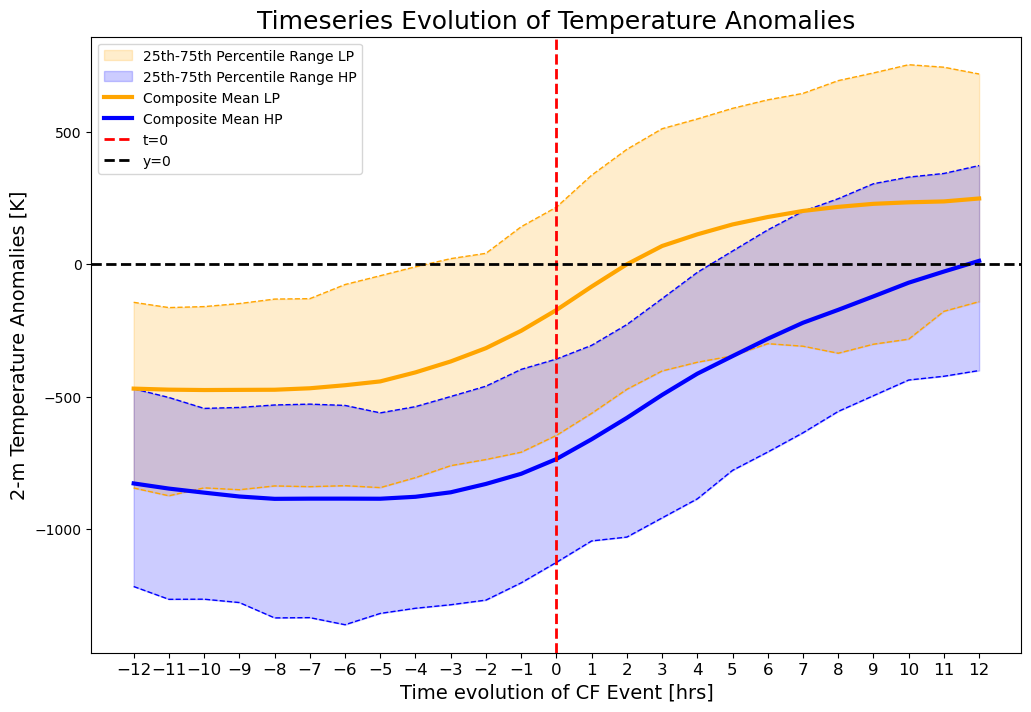

In [53]:
###Plot the quartiles instead of all the cases###

#Calculate the mean, 5th percentile, and 95th percentile#
average_time_series = LP_array.mean(dim='CF_events') 
stdv_time_series = LP_array.std(dim='CF_events')
percentile_15 = LP_array.quantile(0.25, dim='CF_events')
percentile_85 = LP_array.quantile(0.75, dim='CF_events')

average_time_series2 = HP_array.mean(dim='CF_events')
stdv_time_series2 = HP_array.std(dim='CF_events')
percentile_152 = HP_array.quantile(0.25, dim='CF_events')
percentile_852 = HP_array.quantile(0.75, dim='CF_events')

#Plot the mean line and shaded region#
plt.figure(figsize=(12, 8))

#Create the time lag array
time_values = np.arange(-12, 13, 1)  

#Plot the shaded region between the 5th and 95th percentiles#
#LP ones#
plt.fill_between(time_values, percentile_15, percentile_85, color='orange', alpha=0.2, label='25th-75th Percentile Range LP')
plt.plot(time_values, percentile_15, color='orange', linewidth=1, linestyle='--')
plt.plot(time_values, percentile_85, color='orange', linewidth=1,  linestyle='--')

#HP ones#
plt.fill_between(time_values, percentile_152, percentile_852, color='blue', alpha=0.2, label='25th-75th Percentile Range HP')
plt.plot(time_values, percentile_152, color='blue', linewidth=1, linestyle='--')
plt.plot(time_values, percentile_852, color='blue', linewidth=1,  linestyle='--')

#Plot the mean line#
plt.plot(time_values, average_time_series, color='orange', linewidth=3, label='Composite Mean LP')
plt.plot(time_values, average_time_series2, color='blue', linewidth=3, label='Composite Mean HP')

#Add a vertical and horizontal line at t=0 (index 13)#
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='t=0')
plt.axhline(y=0, color='black', linestyle='--', linewidth=2, label='y=0')

#Add labels and titl3#
plt.xlabel('Time evolution of CF Event [hrs]', fontsize=14)
plt.ylabel('2-m Temperature Anomalies [K]', fontsize=14)
plt.title('Timeseries Evolution of Temperature Anomalies', fontsize=18)
plt.legend()

#Draw vertical lines where the y-values are positive#
positive_indices = np.where(average_time_series > 0.5)[0]

#Show all the x range#
#plt.xticks(np.arange(-12,15,3), fontsize=12)
plt.xticks(np.arange(-12,13,1), fontsize=12)

#Add the sample size#
#plt.annotate(f'N={case_N}', xy=(9, 3.5), xytext=(9, 3.5), fontsize=12)

# if len(positive_indices) > 0:
#     first_positive = time_values[positive_indices[0]]
#     last_positive = time_values[positive_indices[-1]]
    
#     #Draw vertical lines at the first and last positive y-values#
#     plt.axvline(x=first_positive, color='orange', linestyle='-', linewidth=2)
#     plt.axvline(x=last_positive, color='orange', linestyle='-', linewidth=2)

plt.show()

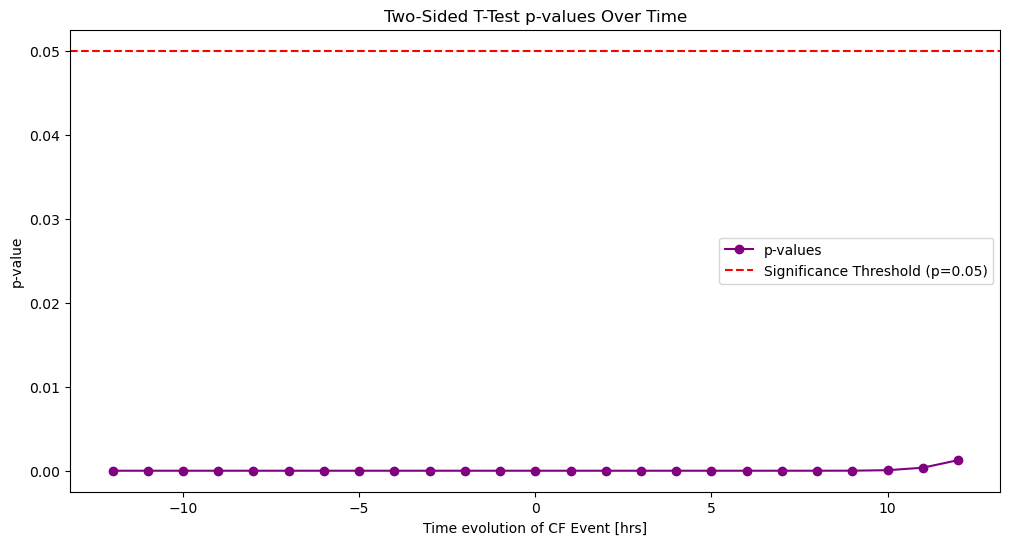

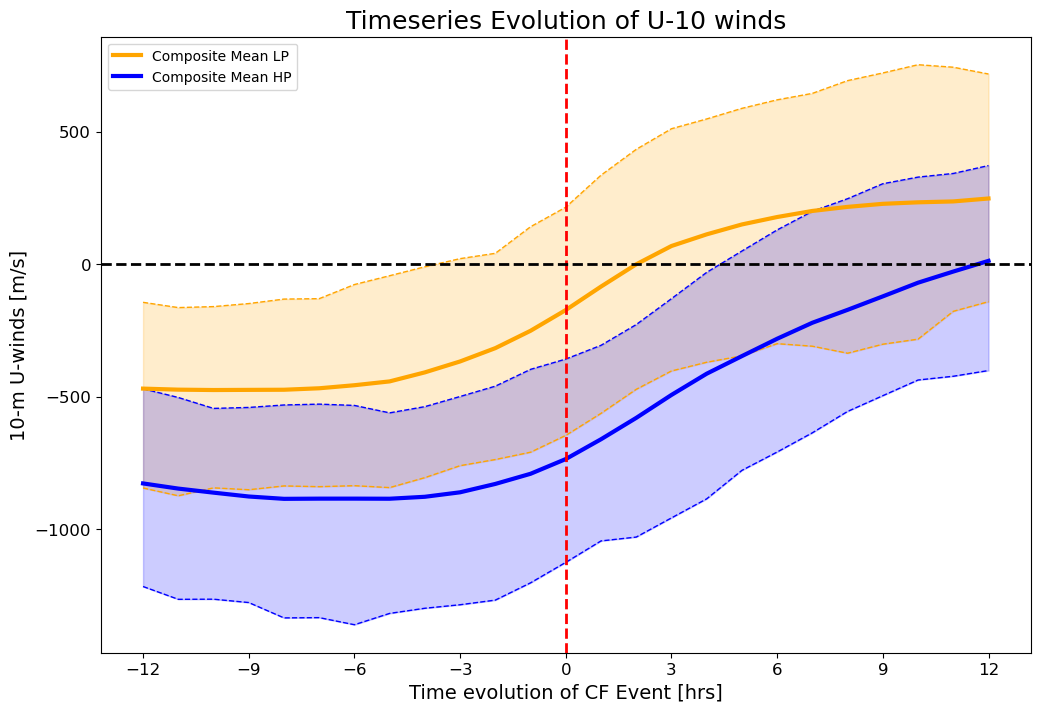

In [54]:
#Statistical Testing of the TS#

#Store the values#
p_values = []
t_stats = []

#Loop over each time point#
for i in range(len(time_values)):
    
    #Extract data for LP and HP at the current time point#
    lp_data = LP_array.isel(time=i).dropna(dim='CF_events').values
    hp_data = HP_array.isel(time=i).dropna(dim='CF_events').values
    
    #Perform two-sided t-test#
    t_stat, p_val = ttest_ind(lp_data, hp_data, equal_var=False)  # Welch's t-test (assuming unequal variance)
    t_stats.append(t_stat)
    p_values.append(p_val)

#Convert p_values and t_stats to numpy arrays for easier manipulation#
p_values = np.array(p_values)
t_stats = np.array(t_stats)

#Plot the p-values to visualize significant time points#
plt.figure(figsize=(12, 6))
plt.plot(time_values, p_values, color='purple', marker='o', linestyle='-', label='p-values')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.xlabel('Time evolution of CF Event [hrs]')
plt.ylabel('p-value')
plt.title('Two-Sided T-Test p-values Over Time')
plt.legend()
plt.show()

significant_times = time_values[p_values < 0.05]  # Extract times with p < 0.05
significant_lp_means = average_time_series[np.where(p_values < 0.05)]  # Corresponding values for LP mean
significant_hp_means = average_time_series2[np.where(p_values < 0.05)] 

#Highlight significant results in the main plot (temperature anomalies plot)#
plt.figure(figsize=(12, 8))

#Plot the time series as before#
plt.fill_between(time_values, percentile_15, percentile_85, color='orange', alpha=0.2)
plt.plot(time_values, percentile_15, color='orange', linewidth=1, linestyle='--')
plt.plot(time_values, percentile_85, color='orange', linewidth=1, linestyle='--')

plt.fill_between(time_values, percentile_152, percentile_852, color='blue', alpha=0.2)
plt.plot(time_values, percentile_152, color='blue', linewidth=1, linestyle='--')
plt.plot(time_values, percentile_852, color='blue', linewidth=1, linestyle='--')

plt.plot(time_values, average_time_series, color='orange', linewidth=3, label='Composite Mean LP')
plt.plot(time_values, average_time_series2, color='blue', linewidth=3, label='Composite Mean HP')

#Add vertical and horizontal reference lines#
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

# #Add circles to mark significant time points where p < 0.05#
# significant_times = time_values[p_values < 0.05]
# significant_times = np.array([-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,6,7,8,9,10,11,12]) 
# significant_lp_means = average_time_series.sel(time=significant_times)
# significant_hp_means = average_time_series2.sel(time=significant_times)

# plt.scatter(time_values, significant_lp_means, color='orange', edgecolor='black', s=100, zorder=5, label='Significant LP')
# plt.scatter(time_values, significant_hp_means, color='blue', edgecolor='black', s=100, zorder=5, label='Significant HP')

#Labels, title, and legend#
plt.xlabel('Time evolution of CF Event [hrs]', fontsize=14)
plt.ylabel('10-m U-winds [m/s]', fontsize=14)
plt.xticks(np.arange(-12,15,3), fontsize=12)
plt.yticks(fontsize=12)
plt.title('Timeseries Evolution of U-10 winds', fontsize=18)
plt.legend()

#plt.savefig("TS_vwinds", dpi=150, bbox_inches='tight', pad_inches=0.1)


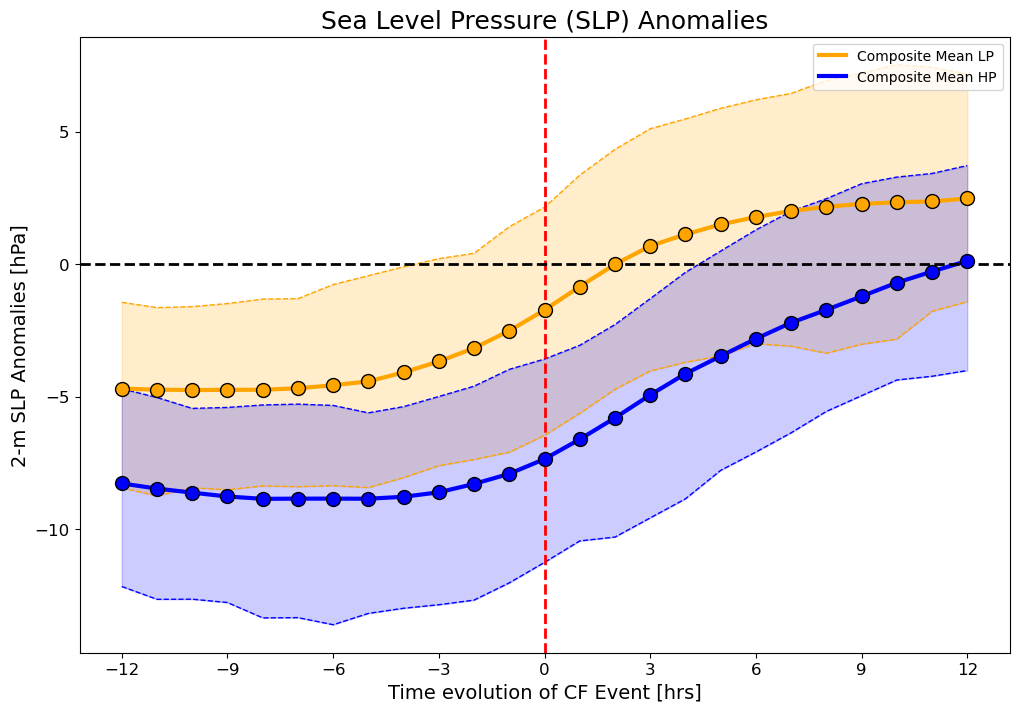

In [63]:
# Identify significant time points
significant_times = time_values[p_values < 0.05]  # Extract times with p < 0.05
significant_lp_means = average_time_series[np.where(p_values < 0.05)]  # Corresponding values for LP mean
significant_hp_means = average_time_series2[np.where(p_values < 0.05)]  # Corresponding values for HP mean

# Highlight significant points on the main plot
plt.figure(figsize=(12, 8))

# Plot the time series as before
plt.fill_between(time_values, percentile_15/100, percentile_85/100, color='orange', alpha=0.2)
plt.plot(time_values, percentile_15/100, color='orange', linewidth=1, linestyle='--')
plt.plot(time_values, percentile_85/100, color='orange', linewidth=1, linestyle='--')

plt.fill_between(time_values, percentile_152/100, percentile_852/100, color='blue', alpha=0.2)
plt.plot(time_values, percentile_152/100, color='blue', linewidth=1, linestyle='--')
plt.plot(time_values, percentile_852/100, color='blue', linewidth=1, linestyle='--')

plt.plot(time_values, average_time_series/100, color='orange', linewidth=3, label='Composite Mean LP')
plt.plot(time_values, average_time_series2/100, color='blue', linewidth=3, label='Composite Mean HP')

# Add vertical and horizontal reference lines
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

# Add circles to mark significant time points where p < 0.05
plt.scatter(significant_times, significant_lp_means/100, color='orange', edgecolor='black', s=100, zorder=5)
plt.scatter(significant_times, significant_hp_means/100, color='blue', edgecolor='black', s=100, zorder=5)

# Labels, title, and legend
plt.xlabel('Time evolution of CF Event [hrs]', fontsize=14)
plt.ylabel('2-m SLP Anomalies [hPa]', fontsize=14)
plt.xticks(np.arange(-12, 15, 3), fontsize=12)
plt.yticks(fontsize=12)
plt.title('Sea Level Pressure (SLP) Anomalies', fontsize=18)
plt.legend(loc='upper right')

# Save or show the figure
#plt.savefig("TS_sp", dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()